In [ ]:
pip install konlpy

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd

import re
from konlpy.tag import Okt
from tqdm import tqdm  #상태진행률 표시
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [47]:
train_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Training.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [48]:
val_data = pd.read_excel('/content/drive/MyDrive/프로젝트1/감성대화말뭉치(최종데이터)_Validation.xlsx')  # 코랩에 올리고 실행되기까지 시간이 좀 걸림.
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [72]:
stop_words = pd.read_excel('/content/drive/MyDrive/프로젝트1/stop_words.xlsx',header=None) 

In [73]:
stop_words = set(stop_words.iloc[:,0])

In [74]:
stop_words

{',',
 '.',
 '가',
 '가지',
 '같',
 '개',
 '것',
 '경우',
 '그',
 '그것',
 '그녀',
 '그러',
 '그러나',
 '그런',
 '그렇',
 '그리고',
 '나',
 '나오',
 '내',
 '년',
 '놓',
 '다른',
 '다시',
 '대하',
 '더',
 '데',
 '되',
 '두',
 '들',
 '등',
 '따르',
 '때',
 '때문',
 '또',
 '만들',
 '많',
 '말',
 '말하',
 '명',
 '모르',
 '못하',
 '문제',
 '받',
 '번',
 '보',
 '보이',
 '사람',
 '사실',
 '사회',
 '살',
 '생각',
 '생각하',
 '소리',
 '속',
 '수',
 '시간',
 '시키',
 '싶',
 '씨',
 '아니',
 '안',
 '않',
 '알',
 '앞',
 '어떤',
 '어떻',
 '없',
 '여자',
 '오',
 '우리',
 '원',
 '월',
 '위하',
 '이',
 '이런',
 '이렇',
 '일',
 '있',
 '자신',
 '잘',
 '적',
 '전',
 '점',
 '정도',
 '좀',
 '좋',
 '주',
 '중',
 '지',
 '지금',
 '집',
 '크',
 '통하',
 '하',
 '하나',
 '한'}

# 데이터에 대한 이해

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

In [51]:
train_data['번호']=train_data['번호'].astype('str')

# 앞뒤 공백 처리.
train_data =train_data.apply(lambda x: x.str.strip() , axis = 1)  #https://www.delftstack.com/ko/howto/python-pandas/difference-between-pandas-apply-map-and-applymap/
train_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,44164,청년,남성,"연애, 결혼, 출산",해당없음,기쁨,신이 난,아내가 드디어 출산하게 되어서 정말 신이 나.,아내분이 출산을 하시는군요. 정말 축하드려요.,아 지금 정말 신이 나.,잘 된 일이네요.,아기가 점점 클게 벌써 기대가 되네. 내가 많이 놀아줘야지.,좋은 아빠가 되실 거 같아요. 진심으로 축하드려요.,NaN,NaN
1,3926,노년,남성,"건강, 죽음",만성질환 유,불안,스트레스 받는,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,약 종류가 많아 번거로우시겠어요.,건강할 때 관리 좀 잘할걸 하는 생각이 들더라고.,현재 상황에서 변화를 주기 위해 어떻게 하면 될까요?,약을 잘 챙겨 먹고 나을 수 있도록 노력해야지.,약을 잘 챙겨 먹어 건강해지시길 바랄게요.,NaN,NaN
2,50882,청소년,여성,학업 및 진로,해당없음,당황,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,고등학교 수업이 중학교 때와는 다르게 갑자기 어려워서 당황스러우시군요.,아직 학기 초인데 내가 수업에 잘 따라갈 수 있을지 걱정돼.,이 상황에서 할 수 있는 게 어떤 것이 있을까요?,중학교 수업을 들을 때보다 훨씬 더 열심히 할 거야.,수업을 어떤 방식으로 열심히 듣는게 좋을까요?,선생님이 강조하신 부분을 필기하고 집에서 매일 수업 내용을 복습하려고 해.,열심히 해서 좋은 결과가 있었으면 좋겠어요.


In [52]:
# 공백제거
val_data['번호']=val_data['번호'].astype('str')
val_data =val_data.apply(lambda x: x.str.strip() , axis = 1)

In [53]:
print('총 감정_대분류의 개수 : {}'.format(len(train_data['감정_대분류'].unique())))
print(train_data['감정_대분류'].unique())

총 감정_대분류의 개수 : 6
['기쁨' '불안' '당황' '슬픔' '분노' '상처']


In [54]:
print('총 감정_소분류의 개수 : {}'.format(len(train_data['감정_소분류'].unique())))
print(train_data['감정_소분류'].unique())

총 감정_소분류의 개수 : 58
['신이 난' '스트레스 받는' '당황' '안도' '취약한' '우울한' '구역질 나는' '좌절한' '눈물이 나는' '배신당한'
 '남의 시선을 의식하는' '죄책감의' '당혹스러운' '분노' '두려운' '낙담한' '회의적인' '마비된' '혼란스러운' '흥분'
 '한심한' '염세적인' '안달하는' '걱정스러운' '조심스러운' '충격 받은' '상처' '불안' '노여워하는' '기쁨' '짜증내는'
 '환멸을 느끼는' '비통한' '혐오스러운' '억울한' '만족스러운' '부끄러운' '버려진' '고립된' '괴로워하는' '자신하는'
 '외로운' '방어적인' '편안한' '질투하는' '감사하는' '초조한' '실망한' '슬픔' '신뢰하는' '가난한, 불우한'
 '후회되는' '툴툴대는' '성가신' '열등감' '희생된' '느긋' '악의적인']


# 감성 레이블 만들기(숫자로 매핑)

In [55]:
#감정 대분류와 소분류를 키값쌍으로 정렬.
dic = {}
for uni_class in train_data['감정_대분류'].unique():
    uni = train_data[train_data['감정_대분류'] == uni_class]['감정_소분류'].unique()
    dic[uni_class] = list(uni)
print(dic['기쁨'])

['신이 난', '안도', '흥분', '기쁨', '만족스러운', '자신하는', '편안한', '감사하는', '신뢰하는', '느긋']


In [56]:
# 감정소분류주제 58개를 숫자레이블 딕셔너리로 변경
feel_class = train_data['감정_소분류'].unique()

i = 0
feel_dic = {}
for feel in feel_class:
    feel_dic[feel] = i
    i+=1
# feel_dic  #key:value = 감정소분류:숫자

In [57]:
# 숫자로 감정을 찾을 수 있도록 reverse
feel_dic_reverse = {}
for key, value in feel_dic.items():
    feel_dic_reverse[value] = key
feel_dic_reverse

{0: '신이 난',
 1: '스트레스 받는',
 2: '당황',
 3: '안도',
 4: '취약한',
 5: '우울한',
 6: '구역질 나는',
 7: '좌절한',
 8: '눈물이 나는',
 9: '배신당한',
 10: '남의 시선을 의식하는',
 11: '죄책감의',
 12: '당혹스러운',
 13: '분노',
 14: '두려운',
 15: '낙담한',
 16: '회의적인',
 17: '마비된',
 18: '혼란스러운',
 19: '흥분',
 20: '한심한',
 21: '염세적인',
 22: '안달하는',
 23: '걱정스러운',
 24: '조심스러운',
 25: '충격 받은',
 26: '상처',
 27: '불안',
 28: '노여워하는',
 29: '기쁨',
 30: '짜증내는',
 31: '환멸을 느끼는',
 32: '비통한',
 33: '혐오스러운',
 34: '억울한',
 35: '만족스러운',
 36: '부끄러운',
 37: '버려진',
 38: '고립된',
 39: '괴로워하는',
 40: '자신하는',
 41: '외로운',
 42: '방어적인',
 43: '편안한',
 44: '질투하는',
 45: '감사하는',
 46: '초조한',
 47: '실망한',
 48: '슬픔',
 49: '신뢰하는',
 50: '가난한, 불우한',
 51: '후회되는',
 52: '툴툴대는',
 53: '성가신',
 54: '열등감',
 55: '희생된',
 56: '느긋',
 57: '악의적인'}

In [58]:
feel_bic_class = train_data['감정_대분류'].unique()

i = 0
feel_bic_dic= {}
for feel in feel_bic_class:
    feel_bic_dic[feel] = i
    i+=1

In [59]:
# 숫자로 감정을 찾을 수 있도록 reverse
feel_bic_dic_reverse = {}
for key, value in feel_bic_dic.items():
    feel_bic_dic_reverse[value] = key
feel_bic_dic_reverse

{0: '기쁨', 1: '불안', 2: '당황', 3: '슬픔', 4: '분노', 5: '상처'}

In [60]:
feel_bic_df = train_data[['감정_대분류','사람문장1']]
feel_bic_df

,감정_대분류,사람문장1
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.
3,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.
4,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.
...,...,...
40874,불안,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...
40875,기쁨,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.
40876,슬픔,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.
40877,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.


In [ ]:
li = []
for feel in feel_bic_df['감정_대분류']:
    li.append(feel_bic_dic[feel])
feel_bic_df['대분류_num'] = li
feel_bic_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,감정_대분류,사람문장1,대분류_num
0,기쁨,아내가 드디어 출산하게 되어서 정말 신이 나.,0
1,불안,당뇨랑 합병증 때문에 먹어야 할 약이 열 가지가 넘어가니까 스트레스야.,1
2,당황,고등학교에 올라오니 중학교 때보다 수업이 갑자기 어려워져서 당황스러워.,2
3,기쁨,재취업이 돼서 받게 된 첫 월급으로 온 가족이 외식을 할 예정이야. 너무 행복해.,0
4,기쁨,빚을 드디어 다 갚게 되어서 이제야 안도감이 들어.,0
...,...,...,...
40874,불안,같이 사는 친구가 애완견을 데려왔는데 대부분 내가 돌보고 있어. 내가 주인인가 혼란...,1
40875,기쁨,지난주에 건강검진 결과가 나왔는데 정상이라고 결과가 나왔어.,0
40876,슬픔,엄마는 내 꿈인 작가를 응원해 주고는 했는데 지금은 안 그래. 너무 슬퍼.,3
40877,기쁨,이렇게 좋은 운동 시설에서 경로 우대로 운동할 수 있다니 참 행운이야.,0


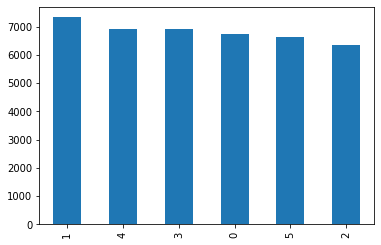

In [ ]:
# 레이블 값의 분포 시각화
plt.figure(figsize=(6, 4))
feel_bic_df['대분류_num'].value_counts().plot(kind='bar');

In [ ]:
print('가장많은 분포의 감정: ', feel_bic_dic_reverse[1])
print('감정분포 2위: ', feel_bic_dic_reverse[4])
print('감정분포 3위: ',feel_bic_dic_reverse[3])
print('감정분포 가장적은: ',feel_bic_dic_reverse[2])

가장많은 분포의 감정:  불안
감정분포 2위:  분노
감정분포 3위:  슬픔
감정분포 가장적은:  당황


In [ ]:
# 각 레이블이 몇개인가
print(feel_bic_df.groupby('대분류_num').size().reset_index(name='count')) 

   대분류_num  count
0        0   6731
1        1   7329
2        2   6360
3        3   6915
4        4   6920
5        5   6624


# train, val 전처리 완료 및 레이블 만들기

In [13]:
# 확인
val_data.head(3)

,번호,연령,성별,상황키워드,신체질환,감정_대분류,감정_소분류,사람문장1,시스템응답1,사람문장2,시스템응답2,사람문장3,시스템응답3,사람문장4,시스템응답4
0,23093,청년,여성,"진로, 취업, 직장",해당없음,분노,툴툴대는,요즘 부모님과 많이 부딪혀.,어떤 일로 부딪히시나요?,난 하고 싶은 일이 있는데 부모님은 안정적인 일만 하라고 하셔. 내 마음대로 하지도...,부모님과의 충돌로 힘드시겠군요.,응. 그래도 난 내가 하고 싶은 일을 위해 노력할 거야.,자신이 하고 싶은 일을 목표로 하기로 하셨군요.,NaN,NaN
1,32848,청소년,남성,가족관계,해당없음,슬픔,비통한,엄마가 결국 집을 나갔어. 너무 너무 슬퍼.,어머니께서 집을 나가셨다니 정말 슬프셨겠어요. 좀 더 자세히 얘기해주시겠어요?,엄마도 엄마만의 인생이 있을 테니 가지 말라고 할 수가 없었어. 그래서 더 마음이 ...,정말 많이 답답하셨겠어요. 어떻게 하는 게 기분이 좀 풀릴까요?,일단 좀 자야겠어.,일단 휴식을 가질 생각이시군요.,NaN,NaN
2,35590,청소년,남성,학교폭력/따돌림,해당없음,불안,조심스러운,학교에서 한 친구를 괴롭히는 무리에게 그만하라고 했어.,용기 있는 행동을 하셨네요. 마음이 어떠셨나요?,그런데 말을 하고 난 후 나도 괴롭힐까 봐 불안했어.,그랬군요. 지금 기분에서 벗어나기 위해 할 수 있는 일에는 무엇이 있을까요?,나는 옳은 일을 한 거라고 생각해. 나까지 괴롭힌다면 신고할 거야.,지금의 상황이 나의 방식으로써 잘 해결될 수 있기를 바라요.,NaN,NaN


In [61]:
# train셋과 val셋 비교
print('총 감정_대분류의 개수 : {}'.format(len(val_data['감정_대분류'].unique())))
set(val_data['감정_대분류'].unique()) == set(train_data['감정_대분류'].unique())

총 감정_대분류의 개수 : 6


True

In [62]:
set(val_data['감정_소분류'].unique()) == set(train_data['감정_소분류'].unique())

True

In [63]:
train_label = []
for feel in train_data['감정_대분류']:
    train_label.append(feel_bic_dic[feel])
np.array(train_label)

array([0, 1, 2, ..., 3, 0, 1])

In [64]:
val_label = []
for feel in val_data['감정_대분류']:
    val_label.append(feel_bic_dic[feel])
pd.Series(val_label)

0       4
1       3
2       1
3       2
4       4
       ..
5125    0
5126    1
5127    4
5128    4
5129    4
Length: 5130, dtype: int64

# 토큰화

In [65]:
from konlpy.tag import Okt
import re

In [75]:
okt=Okt()
X_train = []
for sentence in train_data['사람문장1']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_train.append(stopwords_removed_sentence)
print(X_train[:3])

[['아내', '드디어', '출산', '하다', '되어다', '정말', '신'], ['당뇨', '랑', '합병증', '에', '먹다', '하다', '약', '열', '넘어가다', '스트레스', '야'], ['고등학교', '에', '올라오다', '중학교', '보다', '수업', '갑자기', '어려워지다', '당황', '스럽다']]


In [76]:
X_test = []
for sentence in val_data['사람문장1']:
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stop_words] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

### 정수인코딩

- 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [77]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [78]:
word_index = tokenizer.word_index
print(tokenizer.word_index)   # 여기서 oov는 어떻게 되는거지?

# 0은 패딩을 위해 비워둠

{'하다': 1, '을': 2, '에': 3, '를': 4, '너무': 5, '친구': 6, '있다': 7, '같다': 8, '는': 9, '에서': 10, '도': 11, '없다': 12, '보다': 13, '않다': 14, '은': 15, '좋다': 16, '못': 17, '받다': 18, '이야': 19, '되다': 20, '만': 21, '들다': 22, '에게': 23, '돼다': 24, '회사': 25, '오늘': 26, '요즘': 27, '으로': 28, '돈': 29, '정말': 30, '게': 31, '로': 32, '의': 33, '나르다': 34, '아내': 35, '싶다': 36, '걱정': 37, '스럽다': 38, '한테': 39, '가다': 40, '남편': 41, '이번': 42, '하고': 43, '힘들다': 44, '?': 45, '모르다': 46, '결혼': 47, '나다': 48, '고': 49, '슬프다': 50, '자다': 51, '화가': 52, '다': 53, '많이': 54, '직장': 55, '오다': 56, '과': 57, '기분': 58, '아프다': 59, '!': 60, '마음': 61, '거': 62, '아들': 63, '나오다': 64, '되어다': 65, '당황': 66, '엄마': 67, '준비': 68, '많다': 69, '불안하다': 70, '당하다': 71, '건강': 72, '나이': 73, '해': 74, '랑': 75, '먹다': 76, '병원': 77, '어떻다': 78, '자식': 79, '가족': 80, '와': 81, '이제': 82, '학교': 83, '취업': 84, '부모님': 85, '기쁘다': 86, '인데': 87, '일이': 88, '자꾸': 89, '난': 90, '야': 91, '날': 92, '주다': 93, '아이': 94, '속상하다': 95, '딸': 96, '걸': 97, '노후': 98, '혼자': 99, '짜증': 100, '은퇴': 101, '다니다':

In [79]:
vocab_size = len(tokenizer.word_index) +1     # 단어집합의 크기

In [126]:
vocab_size

9760

In [128]:
max_len

25

In [80]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [81]:
# 훈련 데이터와 테스트 데이터의 문장과 레이블을 각각 저장합니다.
y_train = np.array(train_label)
y_test = np.array(val_label)

In [82]:
print(X_train[:3])
print(y_train)
# 각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다.

[[35, 217, 306, 1, 65, 30, 638], [374, 75, 1070, 3, 76, 1, 277, 634, 1259, 118, 91], [580, 3, 1472, 1403, 13, 613, 111, 1051, 66, 38]]
[0 1 2 ... 3 0 1]


### 패딩

문장의 최대 길이 : 49
문장의 평균 길이 : 10.844051958218156


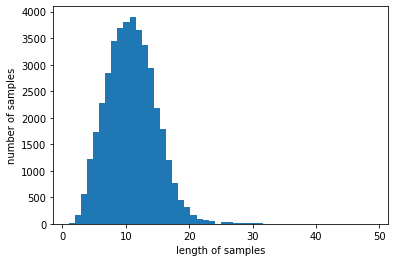

In [83]:
print('문장의 최대 길이 :',max(len(text) for text in X_train))
print('문장의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(text) for text in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

# 전체 데이터의 길이 분포는 대체적으로 약 9내외의 길이를 가지는 것을 볼 수 있습니다. 

In [84]:
# 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))


In [86]:
# 위의 분포 그래프를 봤을 때, max_len = 20이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해봅시다. 채팅 특성상 엄청 긴 문장이 포함되지 않으므로, 최대길이로 모든 데이터를 패딩하면 됨. --> 그러나 별 차이 없었다고 한다.
max_len =  25          # 18 에서 99%
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 25 이하인 샘플의 비율: 99.71623572005186


In [87]:
# 전체 훈련 데이터 중 약 99%의 리뷰가 18이하의 길이를 가지는 것을 확인했습니다. 모든 샘플의 길이를 18으로 맞추겠습니다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [88]:
# 훈련용, 테스트용 뉴스 기사 데이터의 레이블에 원-핫 인코딩을 합니다.
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [89]:
y_train

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]], dtype=float32)

In [90]:
print('전체 데이터의 크기(shape):', X_train.shape)
print('레이블 데이터의 크기(shape):', y_train.shape)

전체 데이터의 크기(shape): (40879, 25)
레이블 데이터의 크기(shape): (40879, 6)


In [91]:
print(X_train[0])
print(y_train[0])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  35 217 306   1  65  30 638]
[1. 0. 0. 0. 0. 0.]


#다층퍼셉트론으로 감성분류

In [129]:
# 모델링은 메모리를 엄청 차지하는 sparse한 형태의 one-hot-encoding 방법이 아니라, 주변 단어들이 나타날 확률을 나타내는 word embedding 방식을 적용한 후에 수행시킨다. word embedding에 대해서는 인터넷 찾아보면 되는데, word2vec, fasttext, glove 등의 방법


from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, Conv1D
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
num_classes =  6  #58


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
model.add(Flatten())


# model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))


es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/50
508/511 [============================>.] - ETA: 0s - loss: 1.3293 - acc: 0.4979
Epoch 00001: val_acc improved from -inf to 0.59944, saving model to best_model.h5
511/511 [==============================] - 8s 15ms/step - loss: 1.3280 - acc: 0.4986 - val_loss: 1.0876 - val_acc: 0.5994
Epoch 2/50
508/511 [============================>.] - ETA: 0s - loss: 0.9220 - acc: 0.6806
Epoch 00002: val_acc improved from 0.59944 to 0.61167, saving model to best_model.h5
511/511 [==============================] - 10s 20ms/step - loss: 0.9220 - acc: 0.6806 - val_loss: 1.0889 - val_acc: 0.6117
Epoch 3/50
510/511 [============================>.] - ETA: 0s - loss: 0.6381 - acc: 0.7917
Epoch 00003: val_acc did not improve from 0.61167
511/511 [==============================] - 7s 14ms/step - loss: 0.6383 - acc: 0.7916 - val_loss: 1.2238 - val_acc: 0.5965
Epoch 4/50
511/511 [==============================] - ETA: 0s - loss: 0.4281 - acc: 0.8644
Epoch 00004: val_acc did not improve from 0.61167
51

In [ ]:
model.load_weights(checkpoint_path)

In [130]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

161/161 [==============================] - 0s 2ms/step - loss: 1.1186 - acc: 0.5969

 테스트 정확도: 0.5969


In [117]:
# pip install pyyaml h5py 

In [116]:
# 이건 가중치만 저장하는거. 모델을 빌드한 다음 가중치를 불러와야 한다.
model.save('best_model_ss.h5')

In [120]:
# 이건 모델 통째로 저장하는 거.https://www.tensorflow.org/tutorials/keras/save_and_load?hl=ko
# !mkdir -p saved_model
model.save('my_model')

# 아래의 명령으로 zip파일로 다운로드 가능.  https://aigong.tistory.com/201   

INFO:tensorflow:Assets written to: saved_model/my_model2/assets


In [125]:
!zip -r /content/my_model.zip /content/my_model

  adding: content/my_model/ (stored 0%)
  adding: content/my_model/variables/ (stored 0%)
  adding: content/my_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/my_model/variables/variables.index (deflated 60%)
  adding: content/my_model/saved_model.pb (deflated 87%)
  adding: content/my_model/assets/ (stored 0%)
  adding: content/my_model/keras_metadata.pb (deflated 86%)


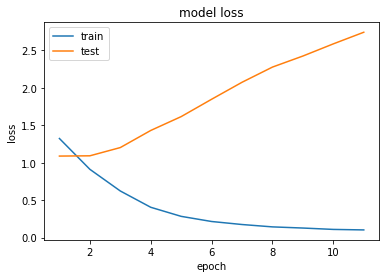

In [35]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
pip install git+https://github.com/ssut/py-hanspell.git

  Cloning https://github.com/ssut/py-hanspell.git to /tmp/pip-req-build-9d93dwj1
  Running command git clone -q https://github.com/ssut/py-hanspell.git /tmp/pip-req-build-9d93dwj1


In [101]:
# 예측해보기
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = loaded_model.predict(pad_new) # 예측
  print(score)
  print(score[0, score.argmax()])
  print(feel_bic_dic_reverse[score.argmax()])
  return feel_bic_dic_reverse[score.argmax()]

In [103]:
feel_bic_dic_reverse

{0: '기쁨', 1: '불안', 2: '당황', 3: '슬픔', 4: '분노', 5: '상처'}

In [107]:
sentiment_predict('돈 많이 벌어서 너무 기분이 좋다')

[[0.750174   0.02107298 0.06019552 0.03032859 0.05010248 0.08812647]]
0.750174
기쁨


'기쁨'

In [108]:
sentiment_predict('바람이 분다')

[[0.17318666 0.06323577 0.16011293 0.14135563 0.09511683 0.36699224]]
0.36699224
상처


'상처'

In [109]:
sentiment_predict('남자친구가 바람났어')

[[0.08336584 0.0687705  0.11138539 0.12375039 0.4420524  0.17067555]]
0.4420524
분노


'분노'

In [114]:
sentiment_predict('엄마랑 쇼핑을 하고왔다')

[[0.2291509  0.17889    0.09517009 0.17864458 0.15245771 0.16568671]]
0.2291509
기쁨


'기쁨'

In [39]:
from hanspell import spell_checker
okt=Okt() 
tokenizer = Tokenizer()
def sentiment_predict(new_sentence):
    # spelled_sent = spell_checker.check(new_sentence)    # 챗봇에 단어를 입력할 때는 비문법이 많으므로 문법을 맞춰주고 띄어쓰기를 시켜준다. 이걸 추가하니까 성능이 훨씬 좋아졌다.
    # hanspell_sent = spelled_sent.checked
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','',new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = 18) # 패딩
    score = model.predict(pad_new) # 예측
    #   print(score[0, score.argmax()])

    return feel_bic_dic_reverse[score.argmax()]

In [40]:
sentiment_predict('행복해')

'슬픔'

# LSTM으로 감성분류

In [ ]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# 임베딩 벡터의 차원은 100으로 정했고, 리뷰 분류를 위해서 은닉 상태의 크기가 128인 LSTM을 사용
embedding_dim = 100
hidden_units = 128
num_classes =  6  # 58

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 검증 데이터 손실(val_loss)이 증가하면, 과적합 징후므로 검증 데이터 손실이 4회 증가하면 학습을 조기 종료(Early Stopping)합니다. 또한, ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장합니다.

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=64, validation_split=0.2)

# 에포크는 총 15번을 수행하겠습니다. 또한 훈련 데이터 중 20%를 검증 데이터로 사용하면서 정확도를 확인합니다.

Epoch 1/50
511/511 [==============================] - ETA: 0s - loss: 1.2402 - acc: 0.5432
Epoch 00001: val_acc improved from -inf to 0.60641, saving model to best_model.h5
511/511 [==============================] - 47s 83ms/step - loss: 1.2402 - acc: 0.5432 - val_loss: 1.0808 - val_acc: 0.6064
Epoch 2/50
511/511 [==============================] - ETA: 0s - loss: 0.9602 - acc: 0.6554
Epoch 00002: val_acc improved from 0.60641 to 0.61057, saving model to best_model.h5
511/511 [==============================] - 31s 61ms/step - loss: 0.9602 - acc: 0.6554 - val_loss: 1.0878 - val_acc: 0.6106
Epoch 3/50
511/511 [==============================] - ETA: 0s - loss: 0.8559 - acc: 0.6960
Epoch 00003: val_acc did not improve from 0.61057
511/511 [==============================] - 31s 60ms/step - loss: 0.8559 - acc: 0.6960 - val_loss: 1.1326 - val_acc: 0.6035
Epoch 4/50
511/511 [==============================] - ETA: 0s - loss: 0.7762 - acc: 0.7218
Epoch 00004: val_acc did not improve from 0.61057


In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

161/161 [==============================] - 2s 9ms/step - loss: 1.1138 - acc: 0.5953

 테스트 정확도: 0.5953


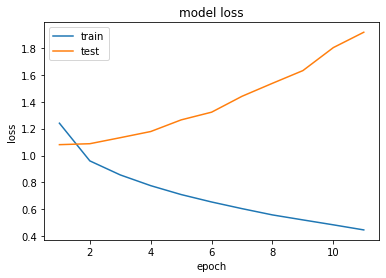

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 예측해보기
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = loaded_model.predict(pad_new) # 예측
#   print(score[0, score.argmax()])
  return feel_bic_dic_reverse[score.argmax()]

In [ ]:
sentiment_predict('사랑해')

'기쁨'

In [ ]:
sentiment_predict('사랑해')

# 사전학습된 워드임베딩을 통한 감성분류

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [ ]:
# 다음으로 사전 훈련된 임베딩의 데이터 덤프를 구문 분석하여 알려진 임베딩에 대한 인덱스 매핑 단어를 계산합니다.  # fasttext의 사전 훈련된 단어 벡터의 차원은 300.
embeddings_index = {}
FASTTEXT_DIR = '/content/drive/MyDrive/프로젝트1'
f = open(os.path.join(FASTTEXT_DIR, 'cc.ko.300.txt'), encoding='utf-8', errors='ignore')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 2000000 word vectors.


In [ ]:
# 이 시점에서 embedding_index사전과 우리 word_index를 활용 하여 임베딩 행렬을 계산할 수 있습니다 .
embedding_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [ ]:
from keras.layers import Embedding

embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

In [ ]:
# 과연 사전학습된 벡터가 효과를 보일것인가!!!

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dropout,Dense, Input, Flatten, Concatenate

embedding_dim = 300
hidden_units = 128
num_classes = 6


sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
lstm_layer = LSTM(hidden_units, dropout=0.2, recurrent_dropout=0.3)(embedded_sequences)
x = Dense(64, activation='relu')(lstm_layer)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=sequence_input, outputs=output)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


# happy learning!
history = model.fit(X_train, y_train, epochs=50, callbacks=[es, mc], batch_size=128, validation_split=0.2)

Epoch 1/50
256/256 [==============================] - ETA: 0s - loss: 1.4486 - acc: 0.4441
Epoch 00001: val_acc improved from -inf to 0.52263, saving model to best_model.h5
256/256 [==============================] - 46s 163ms/step - loss: 1.4486 - acc: 0.4441 - val_loss: 1.2939 - val_acc: 0.5226
Epoch 2/50
256/256 [==============================] - ETA: 0s - loss: 1.2683 - acc: 0.5259
Epoch 00002: val_acc improved from 0.52263 to 0.54574, saving model to best_model.h5
256/256 [==============================] - 41s 160ms/step - loss: 1.2683 - acc: 0.5259 - val_loss: 1.2273 - val_acc: 0.5457
Epoch 3/50
256/256 [==============================] - ETA: 0s - loss: 1.2169 - acc: 0.5448
Epoch 00003: val_acc improved from 0.54574 to 0.55455, saving model to best_model.h5
256/256 [==============================] - 41s 160ms/step - loss: 1.2169 - acc: 0.5448 - val_loss: 1.1982 - val_acc: 0.5545
Epoch 4/50
256/256 [==============================] - ETA: 0s - loss: 1.1766 - acc: 0.5622
Epoch 00004:

In [ ]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

161/161 [==============================] - 2s 13ms/step - loss: 1.1858 - acc: 0.5883

 테스트 정확도: 0.5883


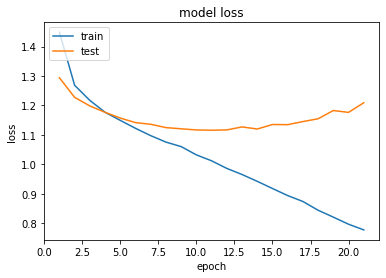

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# 예측해보기
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stop_words] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = loaded_model.predict(pad_new) # 예측
#   print(score[0, score.argmax()])
  return feel_bic_dic_reverse[score.argmax()]

In [ ]:
sentiment_predict('사랑해')


# 내생각엔 아마도, 패스트텍스트에서 미리 훈련한 벡터들이, 감성대화와 연관된 것이 아니라서 감성대화의 벡터를 잘 못잡아내는 것 같다는 생각을 했다. 대화체 문장을 못 잡아내지 않았나 싶음.
# 문법에 강화된 fasttext라 대화형 감성분류에 대해 좀 더 취약했을 것 같다.
# word2vec로 사전학습된 벡터를 사용해볼까 한다. 

'기쁨'